# Normalizing Flow
We train an autoregressive normalizing flow with a standard normal distribution as a base distribution.

We follow the formulation of [Papamakarios et al](https://arxiv.org/pdf/1912.02762). We will create samples from the target distribution and use the forward KL divergence to hopefully learn a flow that does the transformation in a single step.

In [1]:
import torch
import normflows as nf
from matplotlib import pyplot as plt
import numpy as np

## Loading Target Image

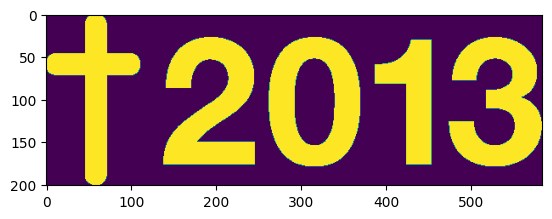

In [2]:
from PIL import Image
image = Image.open("../resources/yod2.png")
image_mask = torch.tensor(np.asarray(image)[:, :, 0] == 0, dtype=bool)

import numpy as np
plt.imshow(image_mask)


## Create Target Distribution
We want the target distribution to be uniform within the image.

In [3]:
# Set up target
class ImageTarget(nf.distributions.Target):
    
    def __init__(self, mask, min_log_prob=-10000):
        # do not do any rescaling or shifting of uniform proposal
        super().__init__(prop_scale=torch.tensor(1.), 
                         prop_shift=torch.tensor(0.))

        self.mask = mask
        self.n_dims = 2
        self.rescale_factor = max(self.mask.shape)
        self.n_rows, self.n_cols = mask.shape

        # calculate density and log density
        density = 1 / (image_mask.float().mean() * (min(self.mask.shape) / max(self.mask.shape)))
        self.log_const = torch.log(density)
        self.max_log_prob = self.log_const
        self.min_log_prob = min_log_prob

    def log_prob(self, x):
        col_ix = (x[:, 0] * self.rescale_factor).int()
        row_ix = ((1 - x[:, 1]) * self.rescale_factor).int()

        clipped_row = torch.clip(row_ix, 0, self.n_rows - 1)
        clipped_col = torch.clip(col_ix, 0, self.n_cols - 1)

        is_in_image = self.mask[clipped_row, clipped_col]
        is_in_bounds = (row_ix == clipped_row) & (col_ix == clipped_col)
        has_zero_probability = ~(is_in_bounds & is_in_image)

        return self.log_const + (has_zero_probability).type(self.log_const.dtype) * self.min_log_prob 

target = ImageTarget(image_mask)

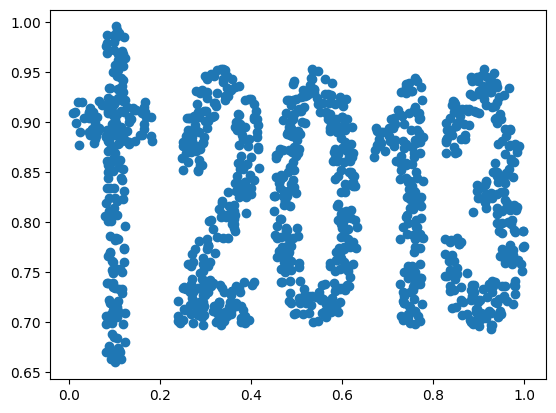

In [4]:
samples = target.rejection_sampling(10000)
plt.scatter(samples[:, 0], samples[:, 1])

## Create Flow Model

Copy-pasted from here: https://github.com/VincentStimper/normalizing-flows/blob/master/examples/real_nvp.ipynb.
Adapted to have more hidden dimensions. 

In [5]:
def create_base():
    return nf.distributions.base.DiagGaussian(2)

base = create_base()

In [6]:
def create_model(create_base):
    base = create_base()
    # Copied from readme of nf package
    num_layers = 32
    latent_size = 2
    b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
    
    flows = []
    for i in range(num_layers):
        s = nf.nets.MLP([latent_size, 16 * latent_size, 16 * latent_size, 16 * latent_size, latent_size], init_zeros=True)
        t = nf.nets.MLP([latent_size, 16 * latent_size, 16 * latent_size, 16 * latent_size, latent_size], init_zeros=True)
        if i % 2 == 0:
            flows += [nf.flows.MaskedAffineFlow(b, t, s)]
        else:
            flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
        flows += [nf.flows.ActNorm(latent_size)]
    return nf.NormalizingFlow(base, flows)

## Training

Epoch=     0. Loss= -1.00. Grad Norm= 0.377

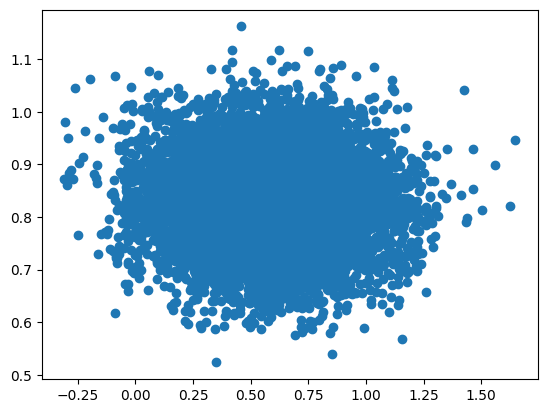

Epoch=  5000. Loss= -1.68. Grad Norm=21.63572

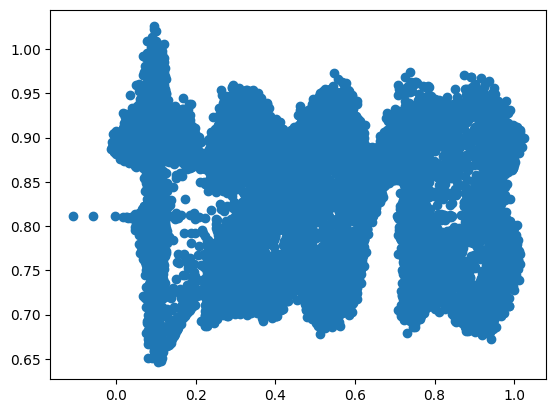

Epoch= 10000. Loss= -1.68. Grad Norm=11.23451

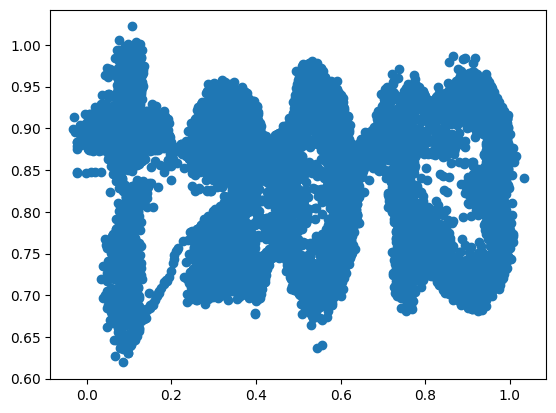

Epoch= 15000. Loss= -1.84. Grad Norm=62.40255

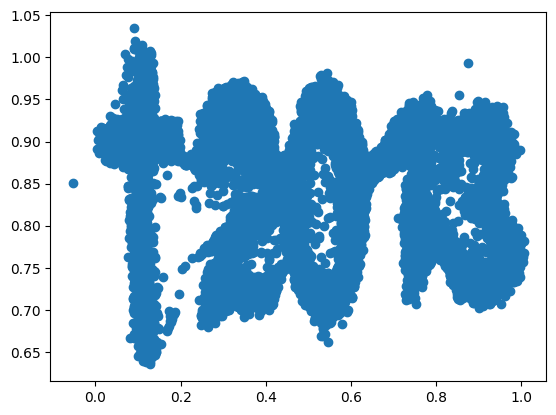

Epoch= 20000. Loss= -1.74. Grad Norm=35.86294

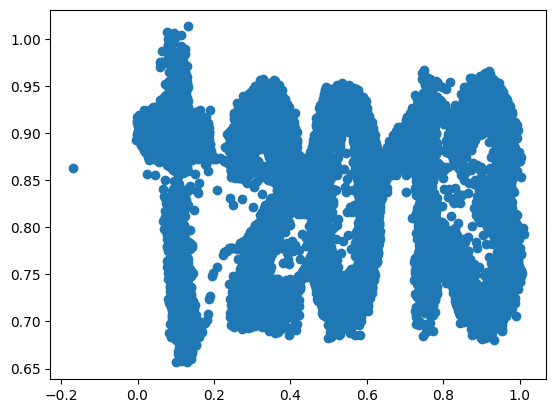

Epoch= 25000. Loss= -1.73. Grad Norm=39.097871

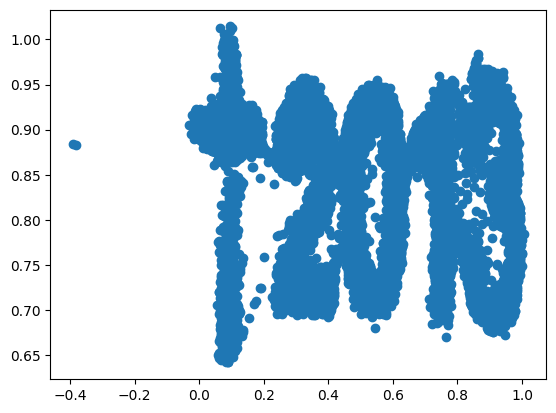

Epoch= 30000. Loss= -1.87. Grad Norm=19.484686

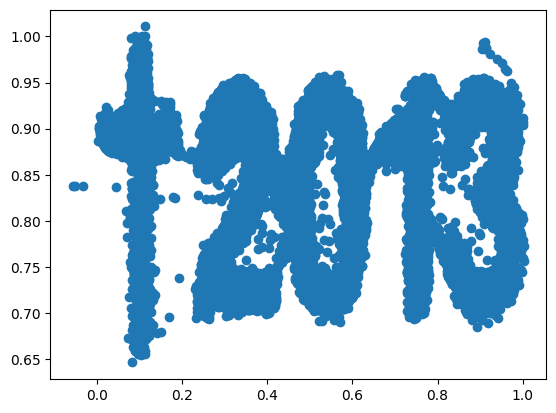

Epoch= 35000. Loss= -1.95. Grad Norm=27.041634

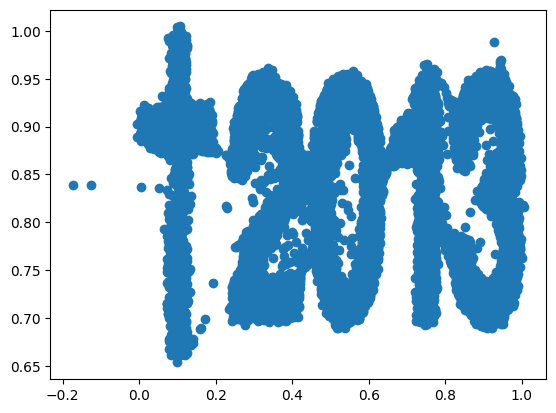

Epoch= 40000. Loss= -2.05. Grad Norm=13.966119

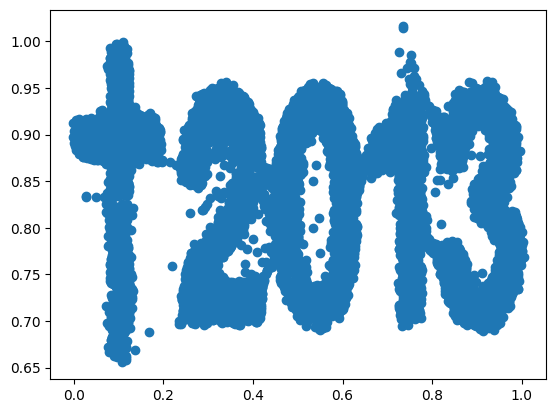

Epoch= 45000. Loss= -2.02. Grad Norm=14.590546

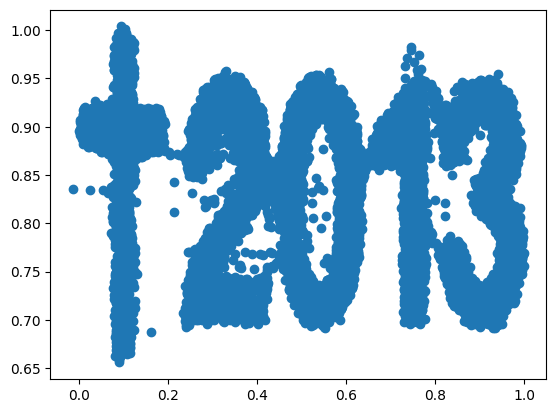

Epoch= 49999. Loss= -2.04. Grad Norm=30.100873

In [8]:
device = torch.device("cpu")
model = create_model(create_base).to(device)

optim = torch.optim.AdamW(params=model.parameters(), lr=.001, weight_decay=0.003)
n_epochs = 50000

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, n_epochs)
n_samples = 512

losses = []
for epoch in range(n_epochs):
    x = target.rejection_sampling(n_samples).to(device)

    optim.zero_grad()
    loss = model.forward_kld(x)
    loss.backward()

    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 50.0)

    optim.step()
    lr_scheduler.step()
    losses.append(loss)

    print(f"\rEpoch={epoch:6d}. Loss={loss.item():6.2f}. Grad Norm={grad_norm:6.3f}", end="")

    if epoch % 5000 == 0:
        samples = base.sample(10000).to(device)
        fwd = model(samples).detach().cpu()
        plt.scatter(fwd[:, 0], fwd[:, 1])
        plt.show()

## Final Model

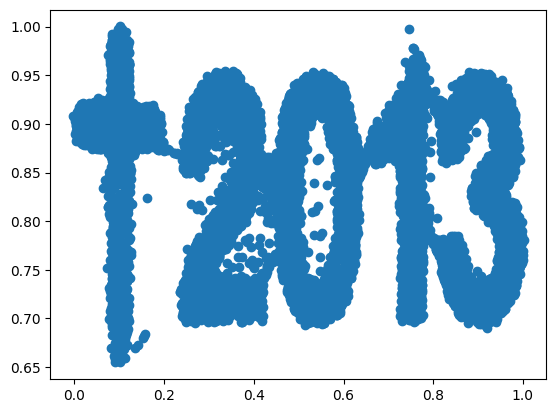

In [9]:
samples = base.sample(10000).to(device)
fwd = model(samples).detach().cpu()
plt.scatter(fwd[:, 0], fwd[:, 1])
plt.show()

## Wrap into Custom Model
This is to make it harder to create samples - we want the puzzlers to figure out that you have to provide standard normal inputs.

In [48]:
class NormalizingFlow(torch.nn.Module):
    num_layers = 32
    latent_size = 2

    def __init__(self, flows=None):
        super().__init__()
        self.flows = flows if flows is not None else self._create_flows()

    def _create_flows(self):
        b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(self.latent_size)])
        flows = []
        for i in range(self.num_layers):
            s = nf.nets.MLP([self.latent_size, 16 * self.latent_size, 16 * self.latent_size, 16 * self.latent_size, self.latent_size], init_zeros=True)
            t = nf.nets.MLP([self.latent_size, 16 * self.latent_size, 16 * self.latent_size, 16 * self.latent_size, self.latent_size], init_zeros=True)
            if i % 2 == 0:
                flows += [nf.flows.MaskedAffineFlow(b, t, s)]
            else:
                flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
            flows += [nf.flows.ActNorm(self.latent_size)]

        return torch.nn.ModuleList(flows)
    
    def forward(self, x):
        for flow in self.flows:
            x = flow(x)[0]
        return x

Initialize it with the trained model.

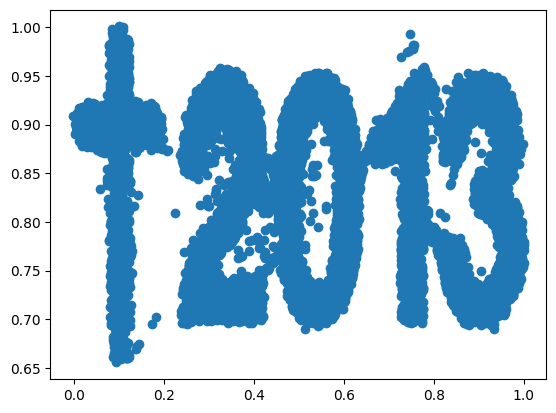

In [49]:
normalizing_flow = NormalizingFlow(model.flows)

samples = base.sample(10000).to(device)
fwd = normalizing_flow(samples).detach().cpu()
plt.scatter(fwd[:, 0], fwd[:, 1])
plt.show()

In [50]:
torch.save(normalizing_flow.state_dict(), "../puzzle/normalizing_flow/torch_state_dict")

new_flow = NormalizingFlow()
new_flow.load_state_dict(torch.load("../puzzle/normalizing_flow/torch_state_dict", weights_only=True))

<All keys matched successfully>

Make sure that the samples still look the same with the new flow.

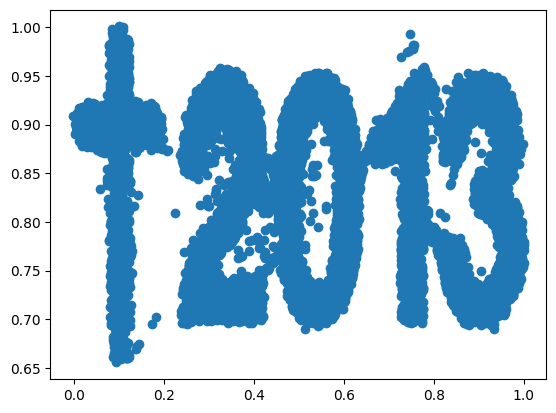

In [52]:
fwd = new_flow(samples).detach().cpu()
plt.scatter(fwd[:, 0], fwd[:, 1])
plt.show()

In [ ]:
model.save()